# OVI detection relationship with X-ray surface brightness profile

In this notebook we explore whether there is a relationship between the detection of OVI in the galaxy groups, and the X-ray surface brightness profile parameters (and the hot gas masses we measure for the groups). This includes re-calculating the impact parameters in terms of the core radius of the beta profile models fit to the surface brightness profiles, comparing them to the slope parameter (beta), and comparing them to the gas masses.

## Import Statements

In [1]:
import pandas as pd
from astropy.units import Quantity, def_unit
import numpy as np
from matplotlib import pyplot as plt

from xga.utils import DEFAULT_COSMO
from xga.sourcetools.misc import ang_to_rad
from xga.utils import r500 as r500_unit

## Defining useful functions

Here we define any functions that are to be used in this notebook:

In [2]:
# This calculates the separation between two RA-DEC points
def hav_sep(ra, dec, ra2, dec2):
    hav_sep = 2 * np.arcsin(np.sqrt((np.sin(((dec2*(np.pi / 180))-(dec*(np.pi / 180))) / 2) ** 2)
                                    + np.cos((dec * (np.pi / 180))) * np.cos(dec2 * (np.pi / 180))
                                    * np.sin(((ra2*(np.pi / 180)) - (ra*(np.pi / 180))) / 2) ** 2))
    # Converting back to degrees from radians
    hav_sep /= (np.pi / 180)
    return Quantity(hav_sep, 'deg')

We also set up an Astropy unit for $R_{core}$ - the core radius of the beta model:

In [3]:
rc_unit = def_unit('rc', format={'latex': r"\mathrm{R_{c}}"})

## Loading data tables

We have to load several data tables to get the information for this notebook. We start by reading in the information on the quasars that were used to measure the line of sight absorption features. This is primarily to retrieve their name and position; the name will be used to match to the relevant group(s), and the position is used to calculate the impact factor:

In [4]:
quas = pd.read_csv('../../sample_files/quasar_info.csv')
quas = quas.rename(columns={'name': 'quasar_name', 'ra': 'quas_ra', 'dec': 'quas_dec', 
                            'redshift': 'quas_redshift'})
quas

,quasar_name,quas_ra,quas_dec,quas_redshift
0,B1612+266,243.544,26.547,0.395
1,FBQS1519+2838,229.901,28.641,0.270
2,SBS0956+509,149.882,50.747,0.143
3,RBS711,129.245,44.434,0.255
4,FBQSJ1030+3102,157.746,31.049,0.178
5,PHL1811,328.756,-9.373,0.201


This file contains the adopted optical central positions, and optically determined radii used by Stocke et al. - they will be used to contrast the results attained through the use of X-ray derived properties:

In [5]:
opt_groups = pd.read_csv("../../sample_files/opt_group_info.csv")
opt_groups

,name,opt_ra,opt_ra_err,opt_dec,opt_dec_err,redshift,ov_obs_ad,r_obs_ad,quasar,OVI_det
0,25124,243.538,0.015,26.687,0.006,0.186,448.0,1167.0,B1612+266,True
1,44739,229.822,0.019,28.342,0.058,0.118,336.0,1135.0,FBQS1519+2838,True
2,19670,150.178,0.028,50.784,0.007,0.134,404.0,991.0,SBS0956+509,False
3,12833,129.400,0.013,44.282,0.010,0.145,444.0,1396.0,RBS711,False
4,J083829.2+441904.8,NaN,NaN,NaN,NaN,0.198,NaN,NaN,RBS711,False
5,44858,230.084,0.035,28.873,0.008,0.127,569.0,1546.0,FBQS1519+2838,True
6,J215504.8-093520,NaN,NaN,NaN,NaN,0.077,NaN,NaN,PHL1811,True
7,J215437.2-091532.4,NaN,NaN,NaN,NaN,0.077,NaN,NaN,PHL1811,True
8,50433,157.732,0.003,30.845,0.006,0.136,338.0,600.0,FBQSJ1030+3102,False


<font color='red'>Why did I bother measuring three different ways if we're only using one??</font>

We read in the data tables containing X-ray properties:

In [6]:
xray_prop = pd.read_csv("../../outputs/results/ltr_r500_pipeline_results.csv")
xray_prop['opt_name'] = xray_prop['name'].apply(lambda x: x[:5] if len(x) <= 7 else x)

# This makes the merging below a bit neater - means there are no column name clashes, everything is clear, and 
#  we don't duplicate information this is already in another DF (the redshift)
xray_prop = xray_prop.rename(columns={'ra': 'xray_ra', 'dec': 'xray_dec'})
del xray_prop['redshift']
xray_prop

,name,xray_ra,xray_dec,r500,r500+-,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,...,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+,opt_name
0,25124A,243.629055,26.730240,893.382668,44.137856,4.083410,0.334322,0.422878,7.141392e+43,1.087654e+42,...,4.158680,0.560650,0.831335,4.376124e+43,1.316098e+42,1.213119e+42,1.309041e+44,1.154301e+43,1.335210e+43,25124
1,25124B,243.504000,26.691000,232.394173,46.383464,2.586690,0.737052,2.403693,1.707848e+42,2.602582e+41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25124
2,25124C,243.541000,26.648000,494.381609,20.414587,1.410110,0.082260,0.093876,6.803658e+42,5.325387e+41,...,1.406590,0.085928,0.094737,6.597141e+42,5.658309e+41,4.671014e+41,1.314807e+43,1.316791e+42,1.058266e+42,25124
3,44739,229.793620,28.331750,419.408006,22.236682,1.053210,0.077640,0.081511,2.141382e+42,2.108863e+41,...,1.024260,0.081872,0.090932,1.729590e+42,3.360183e+41,2.207034e+41,3.026989e+42,5.011803e+41,4.268552e+41,44739
4,19670AB,150.226402,50.800565,572.934243,55.185550,1.325860,0.127974,0.175725,2.589064e+42,4.113469e+41,...,1.271900,0.120733,0.170133,2.137764e+42,3.334210e+41,3.810820e+41,4.119329e+42,9.036346e+41,6.926172e+41,19670
5,19670A,150.256710,50.793942,469.710739,31.768708,1.217230,0.119191,0.135531,1.502793e+42,2.852948e+41,...,1.167150,0.141568,0.188398,1.145528e+42,3.704302e+41,3.244274e+41,2.126675e+42,6.800261e+41,7.860462e+41,19670
6,19670B,150.214920,50.805014,577.830170,45.142869,2.028900,0.287583,0.502016,4.809527e+42,3.964663e+41,...,1.756620,0.264668,0.358291,3.826824e+42,3.990364e+41,4.445714e+41,8.239713e+42,9.896431e+41,1.185665e+42,19670
7,19670C,150.065000,50.746000,448.295618,255.921764,1.334250,0.208387,0.346770,8.381808e+41,3.707784e+41,...,1.262090,0.214472,0.311864,6.159195e+41,3.599597e+41,2.881152e+41,1.182900e+42,5.326862e+41,7.425364e+41,19670
8,19670D,150.168000,50.686000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19670
9,12833A,129.496800,44.248700,495.615682,24.676327,1.340700,0.080378,0.101755,3.418327e+42,2.412858e+41,...,1.324570,0.117213,0.170060,2.147349e+42,3.545853e+41,3.531595e+41,4.205251e+42,7.012826e+41,7.028584e+41,12833


Reading in the gas masses measured from hot gas density profiles:

In [7]:
xray_gm = pd.read_csv("../../outputs/results/all_hot_gm_measurements.csv")

xray_gm

,name,gm500,gm500-,gm500+,gm2500,gm2500-,gm2500+,gm_metfree500,gm_metfree500-,gm_metfree500+,gm_metfree2500,gm_metfree2500-,gm_metfree2500+,gm_froztemp500,gm_froztemp500-,gm_froztemp500+,gm_froztemp2500,gm_froztemp2500-,gm_froztemp2500+
0,25124A,2.7983,0.1615,0.1582,0.8845,0.0450,0.0465,2.7043,0.1707,0.1753,0.8823,0.0533,0.0533,2.7015,0.0584,0.0590,1.0261,0.0222,0.0213
1,25124B,0.0727,0.0204,0.0174,0.0896,0.0089,0.0101,0.1094,0.0133,0.0191,NaN,NaN,NaN,0.1203,0.0169,0.0316,0.0801,0.0061,0.0066
2,25124C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44739,0.0071,0.0012,0.0015,0.0069,0.0010,0.0011,0.0071,0.0012,0.0015,NaN,NaN,NaN,0.0071,0.0012,0.0016,0.0069,0.0010,0.0012
4,19670AB,0.0978,0.0065,0.0066,0.0586,0.0045,0.0046,0.0954,0.0059,0.0060,NaN,NaN,NaN,0.0960,0.0057,0.0054,0.0551,0.0034,0.0034
5,19670A,0.0150,0.0018,0.0021,0.0143,0.0014,0.0015,0.0150,0.0018,0.0021,NaN,NaN,NaN,0.0150,0.0018,0.0021,NaN,NaN,NaN
6,19670B,0.0450,0.0028,0.0029,0.0407,0.0019,0.0020,0.0449,0.0027,0.0028,0.0389,0.0020,0.0021,0.0449,0.0027,0.0028,0.0359,0.0019,0.0019
7,19670C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,12833A,0.1251,0.0096,0.0101,0.0566,0.0031,0.0030,0.1222,0.0096,0.0101,0.0555,0.0032,0.0033,0.1385,0.0109,0.0116,0.0692,0.0035,0.0037
9,12833B,0.1562,0.0181,0.0209,NaN,NaN,NaN,0.1413,0.0159,0.0180,NaN,NaN,NaN,0.1786,0.0181,0.0197,0.0664,0.0048,0.0050


Finally, read in the data table containing surface brightness model parameters:

In [8]:
sb_prop = pd.read_csv("../../outputs/results/sb_beta_mod_pars.csv")

sb_prop

,name,beta,beta-,beta+,r_core,r_core-,r_core+,norm,norm-,norm+
0,25124A,0.683,0.024,0.027,109.693,7.481,7.630,0.106,0.004,0.005
1,25124B,2.038,0.812,0.617,244.750,68.947,58.230,0.003,0.001,0.001
2,25124C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44739,1.857,0.877,0.766,64.339,24.486,18.548,0.012,0.002,0.002
4,19670AB,2.215,0.699,0.492,284.332,63.154,55.228,0.002,0.000,0.000
5,19670A,2.144,0.752,0.553,96.434,24.169,18.769,0.011,0.002,0.002
6,19670B,2.328,0.626,0.422,163.505,28.994,20.315,0.008,0.001,0.001
7,19670C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,12833A,0.872,0.123,0.237,60.847,11.626,18.442,0.025,0.003,0.003
9,12833B,0.641,0.085,0.160,32.399,8.049,12.037,0.035,0.004,0.004


Combining the quasar information, optical group, and X-ray group tables:

In [9]:
comb = pd.merge(quas, opt_groups, left_on='quasar_name', right_on='quasar', how='outer')
comb = pd.merge(comb, xray_prop, left_on='name', right_on='opt_name')
del comb['opt_name']
del comb['name_x']
comb = comb.rename(columns={'name_y': 'name'})
comb = pd.merge(comb, sb_prop, left_on='name', right_on='name')
comb = pd.merge(comb, xray_gm, left_on='name', right_on='name')

comb

,quasar_name,quas_ra,quas_dec,quas_redshift,opt_ra,opt_ra_err,opt_dec,opt_dec_err,redshift,ov_obs_ad,...,gm_metfree500+,gm_metfree2500,gm_metfree2500-,gm_metfree2500+,gm_froztemp500,gm_froztemp500-,gm_froztemp500+,gm_froztemp2500,gm_froztemp2500-,gm_froztemp2500+
0,B1612+266,243.544,26.547,0.395,243.538,0.015,26.687,0.006,0.186,448.0,...,0.1753,0.8823,0.0533,0.0533,2.7015,0.0584,0.0590,1.0261,0.0222,0.0213
1,B1612+266,243.544,26.547,0.395,243.538,0.015,26.687,0.006,0.186,448.0,...,0.0191,NaN,NaN,NaN,0.1203,0.0169,0.0316,0.0801,0.0061,0.0066
2,B1612+266,243.544,26.547,0.395,243.538,0.015,26.687,0.006,0.186,448.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FBQS1519+2838,229.901,28.641,0.270,229.822,0.019,28.342,0.058,0.118,336.0,...,0.0015,NaN,NaN,NaN,0.0071,0.0012,0.0016,0.0069,0.0010,0.0012
4,FBQS1519+2838,229.901,28.641,0.270,230.084,0.035,28.873,0.008,0.127,569.0,...,0.0087,0.1381,0.0066,0.0064,0.2252,0.0098,0.0099,0.1565,0.0041,0.0041
5,SBS0956+509,149.882,50.747,0.143,150.178,0.028,50.784,0.007,0.134,404.0,...,0.0060,NaN,NaN,NaN,0.0960,0.0057,0.0054,0.0551,0.0034,0.0034
6,SBS0956+509,149.882,50.747,0.143,150.178,0.028,50.784,0.007,0.134,404.0,...,0.0021,NaN,NaN,NaN,0.0150,0.0018,0.0021,NaN,NaN,NaN
7,SBS0956+509,149.882,50.747,0.143,150.178,0.028,50.784,0.007,0.134,404.0,...,0.0028,0.0389,0.0020,0.0021,0.0449,0.0027,0.0028,0.0359,0.0019,0.0019
8,SBS0956+509,149.882,50.747,0.143,150.178,0.028,50.784,0.007,0.134,404.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,RBS711,129.245,44.434,0.255,129.400,0.013,44.282,0.010,0.145,444.0,...,0.0101,0.0555,0.0032,0.0033,0.1385,0.0109,0.0116,0.0692,0.0035,0.0037


In [10]:
comb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 63 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   quasar_name          14 non-null     object 
 1   quas_ra              14 non-null     float64
 2   quas_dec             14 non-null     float64
 3   quas_redshift        14 non-null     float64
 4   opt_ra               12 non-null     float64
 5   opt_ra_err           12 non-null     float64
 6   opt_dec              12 non-null     float64
 7   opt_dec_err          12 non-null     float64
 8   redshift             14 non-null     float64
 9   ov_obs_ad            12 non-null     float64
 10  r_obs_ad             12 non-null     float64
 11  quasar               14 non-null     object 
 12  OVI_det              14 non-null     bool   
 13  name                 14 non-null     object 
 14  xray_ra              14 non-null     float64
 15  xray_dec             14 non-null     float

## Calculating impact factors

We perform the simple calculation (using Haversine, but it would probably have been fine just assuming Euclidean) of the separation of the quasar sightlines, and their foreground groups. The angular separation is then converted to a proper distance using our chosen cosmology, and at the redshift of the groups.

### From X-ray group positions

Firstly, we use our newly defined group positions from X-ray data: 

In [11]:
xray_deg_seps = hav_sep(comb['quas_ra'].values, comb['quas_dec'].values, comb['xray_ra'].values, 
                        comb['xray_dec'].values)
xray_kpc_seps = ang_to_rad(xray_deg_seps, comb['redshift'].values, DEFAULT_COSMO)
xray_kpc_seps

<Quantity [2225.22177208, 1664.25483944, 1133.27948289, 2481.6492767 ,
           2521.58383381, 1919.83562146, 2067.90029753, 1869.21459417,
            991.21277217, 2364.03570933, 1400.70740661, 1623.38709296,
           1135.29427505,  795.00116405] kpc>

We put our measured separations in terms of the $R_{core}$ values from the beta model fits to surface brightness:

In [12]:
rc = Quantity(comb['r_core'], 'kpc') / Quantity(1, rc_unit)
rc_err = (Quantity(comb[['r_core-', 'r_core+']], 'kpc') / Quantity(1, rc_unit)).mean(axis=1)

In [13]:
xrc_scale_imp_fac = xray_kpc_seps / rc
xrc_scale_imp_fac_err = (xray_kpc_seps * rc_err) / (rc**2)
xrc_scale_imp_fac

<Quantity [ 20.28590495,   6.79981548,          nan,  38.57146174,
            12.51803964,   6.75209129,  21.44368477,  11.43215556,
                    nan,  38.85213255,  43.23304443, 130.34019213,
            32.18957938,  83.78134303] rc>

Showing the fractional impact factor errors:

In [14]:
xrc_scale_imp_fac_err / xrc_scale_imp_fac

<Quantity [0.0688786 , 0.25981001,        nan, 0.33443168, 0.2437325 ,
           0.20817565, 0.22262895, 0.15078744,        nan, 0.24707874,
           0.3099787 , 0.29859494, 0.0766679 , 0.20328802]>

Also calculating the impact factors in terms of $R_{500}$ measurements:

In [15]:
r500 = Quantity(comb['r500'], 'kpc') / Quantity(1, r500_unit)
r500_err = Quantity(comb['r500+-'], 'kpc') / Quantity(1, r500_unit)

In [16]:
xr500_scale_imp_fac = xray_kpc_seps / r500
xr500_scale_imp_fac_err = (xray_kpc_seps * r500_err) / (r500**2)
xr500_scale_imp_fac

<Quantity [2.49078234, 7.16134495, 2.29231724, 5.91702886, 3.97059016,
           3.35088301, 4.40249738, 3.23488577, 2.21106951, 4.76989691,
           3.10754268, 3.51195463, 1.93858051, 2.03528455] r500>

## OVI Detection

### Impact factor in terms of $R_{\rm{core}}$ of surface-brightness profile

Finally, we make figures to present whether an O VI detection has any relationship with the impact parameter of group center from quasar:

In [17]:
y_stop_start = {'25124A': [0.40, 0.58], '25124B': [0.40, 0.58], '25124C': [0.40, 0.58], 
                '44739': [0.41, 0.57], '44858': [0.41, 0.57], 
                '19670A': [0.40, 0.58], '19670B': [0.40, 0.58], '19670C': [0.40, 0.58], '19670D': [0.40, 0.58], 
                '19670AB': [0.39, 0.59],
                '12833A': [0.40, 0.58], '12833B': [0.40, 0.58], 
                'J083829.2': [0.38, 0.61],
                '50433': [0.41, 0.57], 
                'J215504.8': [0.38, 0.61],
                'J215437.2': [0.38, 0.61]}

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


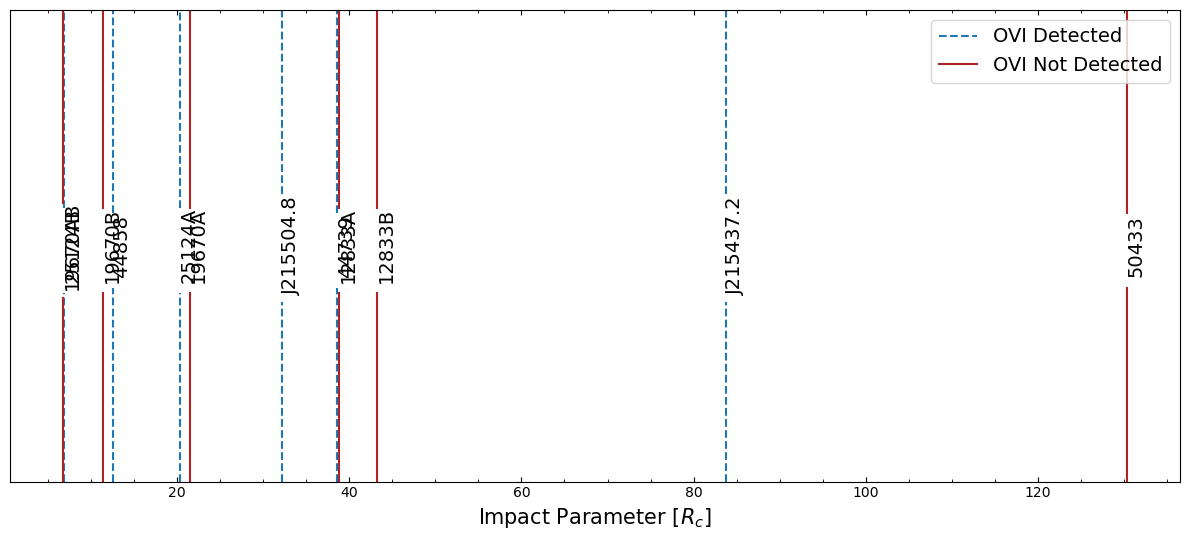

In [18]:
plt.figure(figsize=(12, 5.5))
ax = plt.gca()

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.xlabel(r'Impact Parameter [$R_{c}$]', fontsize=15)

det_lab = False
not_det_lab = False
for row_ind, row in comb.iterrows():
    rel_name = row['name'].split('-')[0].split('+')[0]
    d_rad = xrc_scale_imp_fac[row_ind].value
    ax.annotate(rel_name, (d_rad - 0.04, 0.5), rotation=90, verticalalignment='center',
                             color='black', fontsize=14, xycoords=('data', 'axes fraction'))
    if row['OVI_det']:
        if not det_lab:
            lab = 'OVI Detected'
            det_lab = True
        else:
            lab = ''
        plt.axvline(d_rad, color='tab:blue', linestyle='dashed', 
                    label=lab, ymax=y_stop_start[rel_name][0])
        plt.axvline(d_rad, color='tab:blue', linestyle='dashed', ymin=y_stop_start[rel_name][1], ymax=1)
    else:
        if not not_det_lab:
            lab = 'OVI Not Detected'
            not_det_lab = True
            
        else:
            lab = ''
        plt.axvline(d_rad, color='firebrick', label=lab, ymax=y_stop_start[rel_name][0])
        plt.axvline(d_rad, color='firebrick', ymin=y_stop_start[rel_name][1], ymax=1)
        

plt.yticks([])
plt.legend(loc=1, fontsize=14)
        
plt.tight_layout()
# plt.savefig("../../outputs/figures/xray_sb_rc_impact_par.pdf")
plt.show()

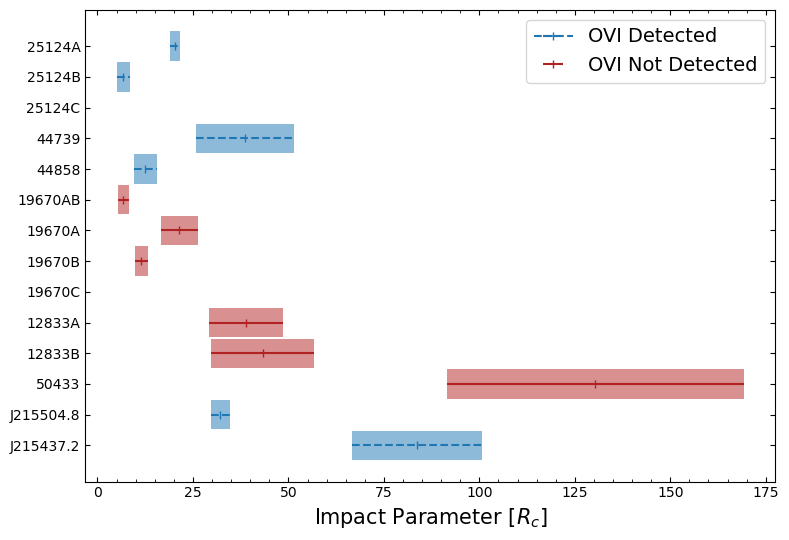

In [19]:
plt.figure(figsize=(8, 5.5))
ax = plt.gca()

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(axis='y', which='minor', width=0)

plt.xlabel(r'Impact Parameter [$R_{c}$]', fontsize=15)

det_lab = False
not_det_lab = False
for row_ind, row in comb.iterrows():
    rel_name = row['name'].split('-')[0].split('+')[0]
    d_rad = xrc_scale_imp_fac[row_ind].value
    d_rad_err = xrc_scale_imp_fac_err[row_ind].value
#     plt.axhline(row_ind-0.48, linestyle='dotted', color='tab:grey')
    
    if np.isnan(d_rad):
        continue

    if row['OVI_det']:
        if not det_lab:
            lab = 'OVI Detected'
            det_lab = True
        else:
            lab = ''
        
        errs = plt.errorbar(d_rad, row_ind, xerr=d_rad_err, fmt='|', color='tab:blue', linestyle='dashed', 
                            label=lab, capsize=0)
        errs[-1][0].set_linestyle('--')
        ax.fill_between([d_rad-d_rad_err, d_rad+d_rad_err], row_ind-0.48, row_ind+0.48, 
                            facecolor='tab:blue', alpha=0.5, interpolate=True)
    else:
        if not not_det_lab:
            lab = 'OVI Not Detected'
            not_det_lab = True
            
        else:
            lab = ''
        plt.errorbar(d_rad, row_ind, xerr=d_rad_err, fmt='|', color='firebrick', 
                    label=lab, capsize=0)
        ax.fill_between([d_rad-d_rad_err, d_rad+d_rad_err], row_ind-0.48, row_ind+0.48, 
                            facecolor='firebrick', alpha=0.5, interpolate=True)
#     plt.axhspan(row_ind-0.48, row_ind+0.48, facecolor='none', edgecolor='black', linestyle='dotted')

chos_names = [n.split('-')[0].split('+')[0] if 'J' in n else n for n in comb['name'].values]
plt.yticks(ticks=range(len(comb)), labels=chos_names)
ax.invert_yaxis()
plt.legend(loc='best', fontsize=14)

plt.tight_layout()
plt.savefig("../../outputs/figures/xray_sb_rc_impact_par_werr.pdf")
plt.show()

### $\beta$ - $R_{\rm{core}}$ Impact Parameter

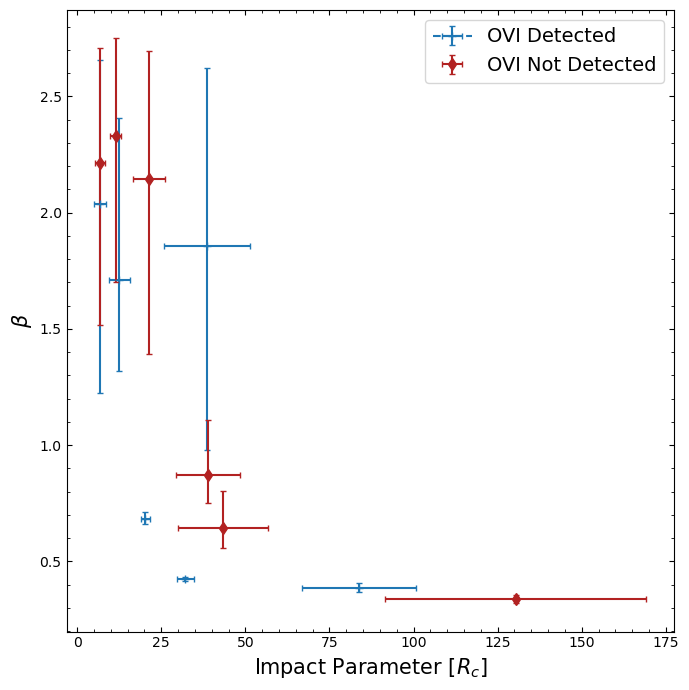

In [20]:
plt.figure(figsize=(7, 7))
ax = plt.gca()

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.xlabel(r'Impact Parameter [$R_{c}$]', fontsize=15)
plt.ylabel(r'$\beta$', fontsize=15)

det_lab = False
not_det_lab = False
for row_ind, row in comb.iterrows():
    rel_name = row['name'].split('-')[0].split('+')[0]
    d_rad = xrc_scale_imp_fac[row_ind].value
    d_rad_err = xrc_scale_imp_fac_err[row_ind].value
    
    beta = row['beta']
    beta_err = row[['beta-', 'beta+']].values
    
    if np.isnan(d_rad):
        continue

    if row['OVI_det']:
        if not det_lab:
            lab = 'OVI Detected'
            det_lab = True
        else:
            lab = ''
        
        errs = plt.errorbar(d_rad, beta, xerr=d_rad_err, yerr=beta_err[..., None], fmt='+', color='tab:blue', 
                            linestyle='dashed', label=lab, capsize=2)
    else:
        if not not_det_lab:
            lab = 'OVI Not Detected'
            not_det_lab = True
            
        else:
            lab = ''
        plt.errorbar(d_rad, beta, xerr=d_rad_err, yerr=beta_err[..., None], fmt='d', color='firebrick', 
                    label=lab, capsize=2)

plt.legend(loc='best', fontsize=14)
plt.tight_layout()
plt.savefig("../../outputs/figures/xray_sb_beta_rc_impact_par_werr.pdf")
plt.show()

### $\beta$ - $R_{500}$ Impact Parameter

/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1105: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1106: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1105: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/mnt/home/turne540/software/anaconda3/en

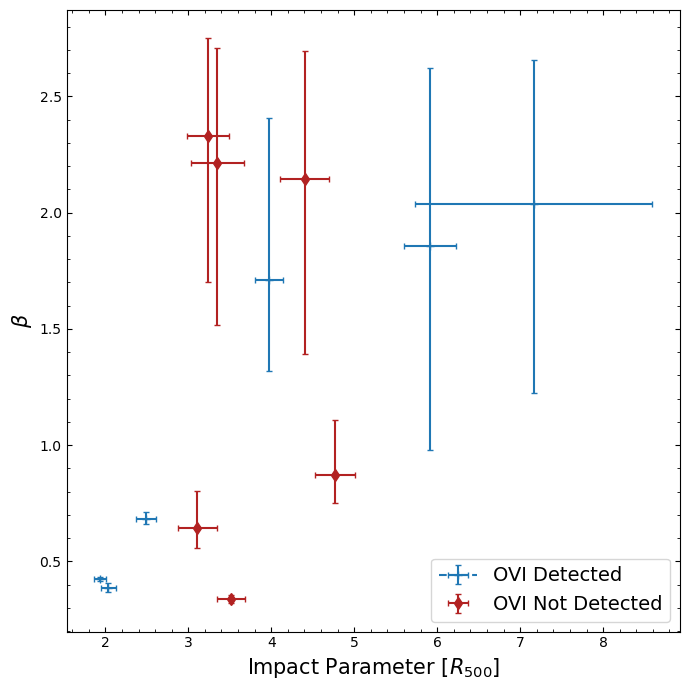

In [21]:
plt.figure(figsize=(7, 7))
ax = plt.gca()

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.xlabel(r'Impact Parameter [$R_{500}$]', fontsize=15)
plt.ylabel(r'$\beta$', fontsize=15)

det_lab = False
not_det_lab = False
for row_ind, row in comb.iterrows():
    rel_name = row['name'].split('-')[0].split('+')[0]
    d_rad = xr500_scale_imp_fac[row_ind].value
    d_rad_err = xr500_scale_imp_fac_err[row_ind].value
    
    beta = row['beta']
    beta_err = row[['beta-', 'beta+']].values
    
    if np.isnan(d_rad):
        continue

    if row['OVI_det']:
        if not det_lab:
            lab = 'OVI Detected'
            det_lab = True
        else:
            lab = ''
        
        errs = plt.errorbar(d_rad, beta, xerr=d_rad_err, yerr=beta_err[..., None], fmt='+', color='tab:blue', 
                            linestyle='dashed', label=lab, capsize=2)
    else:
        if not not_det_lab:
            lab = 'OVI Not Detected'
            not_det_lab = True
            
        else:
            lab = ''
        plt.errorbar(d_rad, beta, xerr=d_rad_err, yerr=beta_err[..., None], fmt='d', color='firebrick', 
                    label=lab, capsize=2)

plt.legend(loc='best', fontsize=14)
plt.tight_layout()
plt.savefig("../../outputs/figures/xray_sb_beta_r500_impact_par_werr.pdf")
plt.show()

### Gas Mass - $R_{500}$ Impact Parameter

/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1105: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1106: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1105: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/mnt/home/turne540/software/anaconda3/en

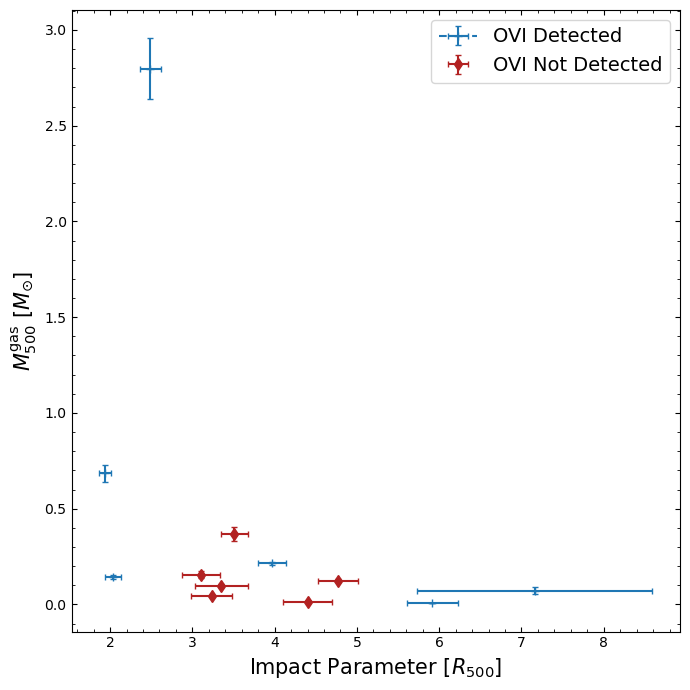

In [22]:
plt.figure(figsize=(7, 7))
ax = plt.gca()

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.xlabel(r'Impact Parameter [$R_{500}$]', fontsize=15)
plt.ylabel(r'$M^{\rm{gas}}_{\rm{500}}$ [$M_{\odot}$]', fontsize=15)

det_lab = False
not_det_lab = False
for row_ind, row in comb.iterrows():
    rel_name = row['name'].split('-')[0].split('+')[0]
    d_rad = xr500_scale_imp_fac[row_ind].value
    d_rad_err = xr500_scale_imp_fac_err[row_ind].value
    
    gm = row['gm500']
    gm_err = row[['gm500-', 'gm500+']].values
    
    if np.isnan(d_rad):
        continue

    if row['OVI_det']:
        if not det_lab:
            lab = 'OVI Detected'
            det_lab = True
        else:
            lab = ''
        
        errs = plt.errorbar(d_rad, gm, xerr=d_rad_err, yerr=gm_err[..., None], fmt='+', color='tab:blue', 
                            linestyle='dashed', label=lab, capsize=2)
    else:
        if not not_det_lab:
            lab = 'OVI Not Detected'
            not_det_lab = True
            
        else:
            lab = ''
        plt.errorbar(d_rad, gm, xerr=d_rad_err, yerr=gm_err[..., None], fmt='d', color='firebrick', 
                    label=lab, capsize=2)

plt.legend(loc='best', fontsize=14)
plt.tight_layout()
plt.savefig("../../outputs/figures/xray_gmass_r500_impact_par_werr.pdf")
plt.show()